# Infilling

In this notebook we demonstrate Silicone's infilling methods.

## Imports

In [1]:
# NBVAL_IGNORE_OUTPUT
import os.path

import pandas as pd
import pyam
import matplotlib.pyplot as plt

import silicone.database_crunchers

<IPython.core.display.Javascript object>

## Constants

In [2]:
SR15_SCENARIOS = "./sr15_scenarios.csv"

## Example data

Here we pull some example data by downloading a selection of the SR1.5 scenarios.

In [3]:
def get_sr15_scenarios(output_file):
    conn = pyam.iiasa.Connection("iamc15")
    valid_model_ids = [
        "MESSAGE*",
        "AIM*",
        "C-ROADS*",
        "GCAM*",
        "IEA*",
        "IMAGE*",
        "MERGE*",
        "POLES*",
        "REMIND*",
        "WITCH*"
    ]
    variables_to_fetch = [
        "Emissions*",
    ]
    for model in valid_model_ids:
        print("Fetching data for {}".format(model))
        for variable in variables_to_fetch:
            print("Fetching {}".format(variable))
            var_df = conn.query(model=model, variable=variable, region='World')
            try:
                df.append(var_df, inplace=True)
            except NameError:
                df = pyam.IamDataFrame(var_df)

    print("Writing to {}".format(output_file))
    df.to_csv(output_file)

In [4]:
# NBVAL_IGNORE_OUTPUT
if not os.path.isfile(SR15_SCENARIOS):
    get_sr15_scenarios(SR15_SCENARIOS)

### Starting point

Our starting point is the test data, loaded a `pyam.IamDataFrame`.

In [5]:
# NBVAL_IGNORE_OUTPUT
sr15_data = pyam.IamDataFrame(SR15_SCENARIOS)
sr15_data.timeseries().head()

INFO:root:Reading `./sr15_scenarios.csv`


2000  \
model       scenario               region variable                                           unit              
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr    NaN   
                                          Emissions|CH4                                      Mt CH4/yr   NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr   NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr   NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr   NaN   

                                                                                                            2005  \
model       scenario               region variable                                           unit                  
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr     8.3367   
                                          Emissions|CH4                                      Mt CH4/yr  344.9167   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr  167.6717   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr    0.4732   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr   11.2639   

                                                                                                            2010  \
model       scenario               region variable                                           unit                  
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr     7.6408   
                                          Emissions|CH4                                      Mt CH4/yr  367.7457   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr  179.6356   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr    0.5168   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr   11.1249   

                                                                                                        2014  \
model       scenario               region variable                                           unit              
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr    NaN   
                                          Emissions|CH4                                      Mt CH4/yr   NaN   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr   NaN   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr   NaN   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr   NaN   

                                                                                                            2015  \
model       scenario               region variable                                           unit                  
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|BC                                       Mt BC/yr     7.2724   
                                          Emissions|CH4                                      Mt CH4/yr  380.4086   
                                          Emissions|CH4|AFOLU                                Mt CH4/yr  190.3513   
                                          Emissions|CH4|Energy|Demand|Industry               Mt CH4/yr    0.5587   
                                          Emissions|CH4|Energy|Demand|Residential and Com... Mt CH4/yr   10.9809   

                                                                                               

## Crunchers

Silicone's 'crunchers' are used to determine the relationship between a 'follower variable' and 'lead variable(s)' from a given database. The 'follower variable' is the variable for which we want to generate data e.g. `Emissions|C3F8` while the 'lead variable(s)' is the variable we want to use in order to infer a timeseries of the 'follower variable'. The lead variable is typically CO$_2$ but might be a more complex combination of gases e.g. CO$_2$, CH$_4$ and N$_2$O. 

Each cruncher has a `derive_relationship` method. Its docstring describes what it does.

In [6]:
print(silicone.database_crunchers.base._DatabaseCruncher.derive_relationship.__doc__)
# # an alternative interface is shown if you use the line below instead
# silicone.database_crunchers.base._DatabaseCruncher.derive_relationship?


        Derive the relationship between two variables from the database

        Parameters
        ----------
        variable_follower : str
            The variable for which we want to calculate timeseries (e.g.
            ``"Emissions|C5F12"``).

        variable_leaders : list[str]
            The variables we want to use in order to infer timeseries of
            ``variable_follower`` (e.g. ``["Emissions|CO2", "Emissions|CH4"]``)

        **kwargs
            Keyword arguments used by this class to derive the relationship between
            ``variable_follower`` and ``variable_leaders``.

        Returns
        -------
        :obj:`func`
            Function which takes a :obj:`pyam.IamDataFrame` containing
            ``variable_leaders`` timeseries and returns timeseries for
            ``variable_follower`` based on the derived relationship between the two.
            Please see the source code for the exact definition (and docstring) of the
            returned functi

These crunchers are best explored by looking at the examples below.

### Lead-gas cruncher

This cruncher uses the 'lead-gas' methodology. It is described by its docstring.

In [7]:
print(silicone.database_crunchers.DatabaseCruncherLeadGas.__doc__)
# silicone.database_crunchers.DatabaseCruncherLeadGas?


    Database cruncher which uses the 'lead gas' technique.

    This cruncher derives the relationship between two variables by simply assuming
    that the follower timeseries is equal to the lead timeseries multiplied by a
    scaling factor. The scaling factor is derived by calculating the ratio of the
    follower variable to the lead variable in the only year in which the follower
    variable is available in the database. As a result, if the follower variable has
    more than one point in the database, this cruncher cannot be used. Additionally,
    the derived relationship only depends on a single point in the database, no
    regressions or other calculations are performed.

    Once the relationship is derived, the 'filler' function will infill following:

    .. math::
        E_f(t) = s * E_l(t)

    where :math:`E_f(t)` is emissions of the follower variable and :math:`E_l(t)` is
    emissions of the lead variable.

    :math:`s` is the scaling factor, calculated as

    .

With a lead-gas cruncher, if we add an estimate for present day emissions of a gas, we can then create timeseries which assume that future emissions simply follow the shape of data already in the database.

In the example below, we will assume that `Emissions|C5F12` follows the trajectory of `Emissions|PFC` in the database.

#### Infilling

Firstly, we add an estimate of `Emissions|C5F12` for 2015 to our SR1.5 data.

In [8]:
emms_c5f12_2015 = pyam.IamDataFrame(pd.DataFrame(
    [["Emissions|C5F12", "World", "unspecified", "historical", 0.0523, "kt C5F12/yr", 2015]],
    columns=["variable", "region", "model", "scenario", "value", "unit", "year"]
))
emms_c5f12_2015.timeseries()

,,,,,2015
model,scenario,region,variable,unit,
unspecified,historical,World,Emissions|C5F12,kt C5F12/yr,0.0523


In [9]:
sr15_data = sr15_data.append(emms_c5f12_2015)

Then we derive the relationship between `Emissions|C5F12` and `Emissions|PFC`.

In [10]:
cruncher = silicone.database_crunchers.DatabaseCruncherLeadGas(sr15_data)

In [11]:
filler = cruncher.derive_relationship("Emissions|C5F12", ["Emissions|PFC"])
print(filler.__doc__)
# filler?


            Filler function derived from :obj:`DatabaseCruncherLeadGas`.

            Parameters
            ----------
            in_iamdf : :obj:`pyam.IamDataFrame`
                Input data to fill data in

            interpolate : bool
                If the key year for filling is not in ``in_iamdf``, should a value be
                interpolated?

            Returns
            -------
            :obj:`pyam.IamDataFrame`
                Filled in data (without original source data)

            Raises
            ------
            ValueError
                The key year for filling is not in ``in_iamdf`` and ``interpolate is
                False``.
            


Now we can infill the SR1.5 data.

In [12]:
# NBVAL_IGNORE_OUTPUT
sr15_data_infilled = filler(sr15_data)
sr15_data_infilled.timeseries().head()

2005  \
model       scenario               region variable        unit                
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr   NaN   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr   NaN   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr   NaN   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr   NaN   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr   NaN   

                                                                           2010  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.051552   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.054382   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.051552   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.047707   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.047707   

                                                                         2015  \
model       scenario               region variable        unit                  
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.0523   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.0523   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.0523   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.0523   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.0523   

                                                                           2020  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.051543   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.049427   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.051543   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.054410   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.054409   

                                                                           2025  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.024494   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.034777   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.024537   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.045759   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.045720   

                                                                           2030  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.005976   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.022025   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.006001   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.035110   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.035089   

                                                                           2035  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr  0.003961   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.014924   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr  0.003976   
            ADVANCE_2030_Med2C     World  Emissions|C5F12 kt C5F12/yr  0.032010   
            ADVANCE_2030_Price1.5C World  Emissions|C5F12 kt C5F12/yr  0.031531   

                                       

A quick plot shows that `Emissions|C5F12` has been downscaled by simply extending the historical estimate and copying the shape of `Emissions|PFC`.

INFO:root:>=13 labels, not applying legend
INFO:root:>=13 labels, not applying legend


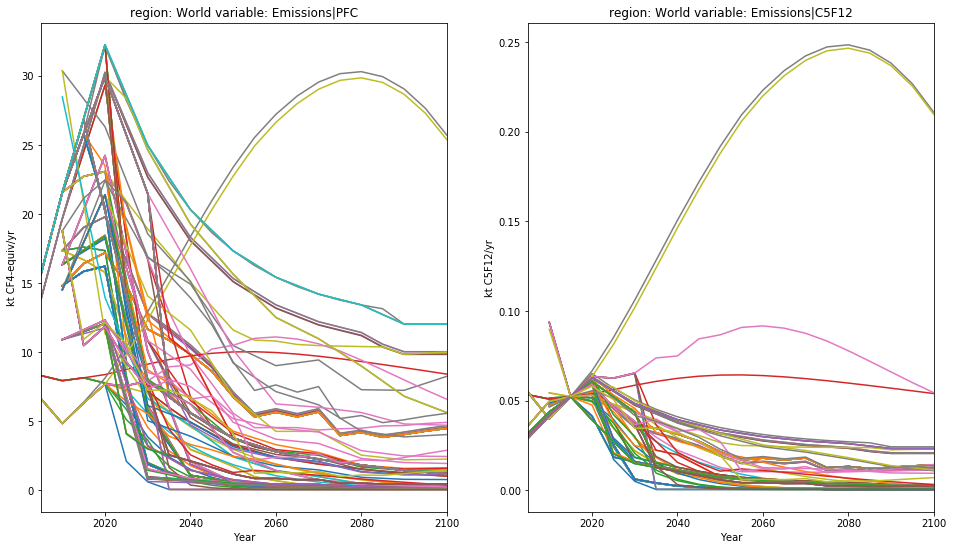

In [13]:
fig = plt.figure(figsize=(16, 9))

ax = fig.add_subplot(121)
sr15_data.filter(variable="Emissions|PFC").line_plot(color="scenario", ax=ax)

ax = fig.add_subplot(122)
sr15_data_infilled.filter(variable="Emissions|C5F12").line_plot(color="scenario", ax=ax);

As the user, you could then append the infilled data to the original data to create a more detailed database.

In [14]:
# NBVAL_IGNORE_OUTPUT
sr15_data_plus = sr15_data.append(sr15_data_infilled)
sr15_data_plus.filter(variable=["*PFC", "*C5F12"]).timeseries().head()

2005  \
model       scenario               region variable        unit                    
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr       NaN   
                                          Emissions|PFC   kt CF4-equiv/yr   NaN   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr       NaN   
                                          Emissions|PFC   kt CF4-equiv/yr   NaN   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr       NaN   

                                                                                2010  \
model       scenario               region variable        unit                         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr       0.051552   
                                          Emissions|PFC   kt CF4-equiv/yr  17.356284   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr       0.054382   
                                          Emissions|PFC   kt CF4-equiv/yr  17.356284   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr       0.051552   

                                                                                2015  \
model       scenario               region variable        unit                         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr       0.052300   
                                          Emissions|PFC   kt CF4-equiv/yr  17.608029   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr       0.052300   
                                          Emissions|PFC   kt CF4-equiv/yr  16.691881   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr       0.052300   

                                                                                2020  \
model       scenario               region variable        unit                         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr       0.051543   
                                          Emissions|PFC   kt CF4-equiv/yr  17.353104   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr       0.049427   
                                          Emissions|PFC   kt CF4-equiv/yr  15.775032   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr       0.051543   

                                                                                2025  \
model       scenario               region variable        unit                         
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr       0.024494   
                                          Emissions|PFC   kt CF4-equiv/yr   8.246335   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr       0.034777   
                                          Emissions|PFC   kt CF4-equiv/yr  11.099369   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr       0.024537   

                                                                               2030  \
model       scenario               region variable        unit                        
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr      0.005976   
                                          Emissions|PFC   kt CF4-equiv/yr  2.011973   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/yr      0.022025   
                                          Emissions|PFC   kt CF4-equiv/yr  7.029343   
            ADVANCE_2020_WB2C      World  Emissions|C5F12 kt C5F12/yr      0.006001   

                                                                               2035  \
model       scenario               region variable        unit                        
AIM/CGE 2.0 ADVANCE_2020_1.5C-2100 World  Emissions|C5F12 kt C5F12/yr      0.003961   
                                          Emissions|PFC   kt CF4-equiv/yr  1.333650   
            ADVANCE_2020_Med2C     World  Emissions|C5F12 kt C5F12/